<a href="https://colab.research.google.com/github/omerhac/osic-fibrosis/blob/master/exponent_functions_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# images path
IMAGES_GCS_PATH = 'gs://osic_fibrosis/images'

In [3]:
# clone and copy repository
!git clone --single-branch --branch table_data_preprocessing https://github.com/omerhac/osic-fibrosis.git
!cp -r osic-fibrosis/* ./

Cloning into 'osic-fibrosis'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 440 (delta 37), reused 31 (delta 12), pack-reused 368
Receiving objects: 100% (440/440), 56.33 MiB | 35.87 MiB/s, done.
Resolving deltas: 100% (267/267), done.


# Visualize prediction graphs

In [4]:
import table_data
import predict 
import visualize

exp_dict = table_data.get_exp_fvc_dict()
train_table = table_data.get_train_table()

# create exponent functiosn dict
func_dict = {}
for id in exp_dict:
  i_week, i_fvc = table_data.get_initial_fvc(id)
  func_dict[id] = predict.ExpFunc(i_fvc, exp_dict[id], i_week)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


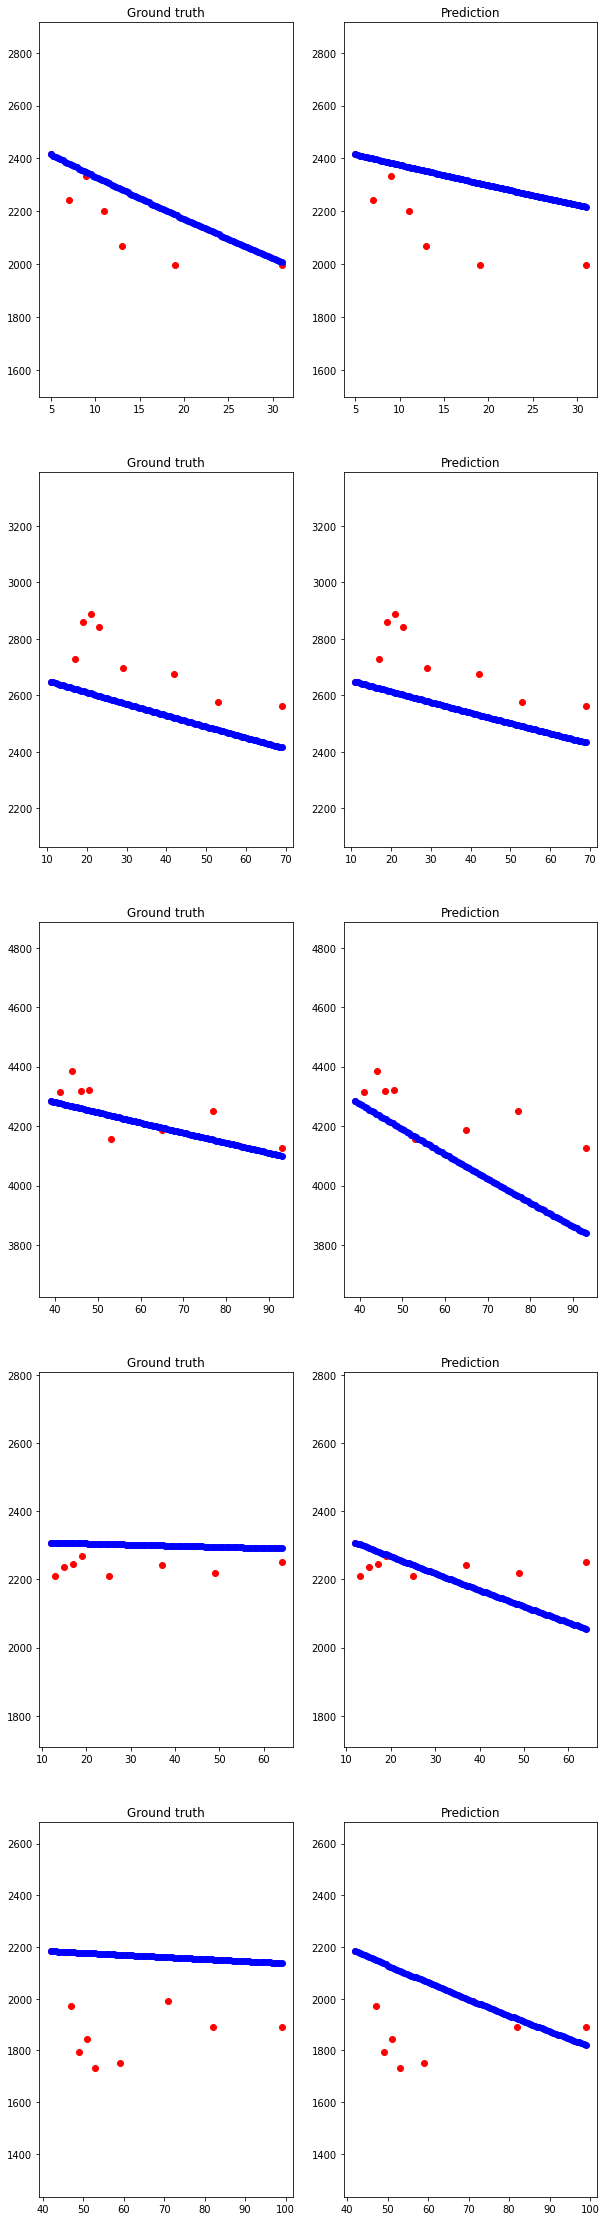

In [5]:
# plot one patient predicted graph
exp_gen = predict.exponent_generator(IMAGES_GCS_PATH + '/validation')

# init plot
fig, ax = plt.subplots(5, 2, figsize=(10, 40))

# visualize prediction vs ground truth graphs
for i, (id, exp_func) in enumerate(exp_gen):
  gt_func = func_dict[id]  # get ground truth function

  # plot ground truth
  visualize.plot_patient_exp(id, exp_function=gt_func, ax=ax[i, 0])
  ax[i, 0].set_title("Ground truth")

  # plot prediction
  visualize.plot_patient_exp(id, exp_function=exp_func, ax=ax[i, 1])
  ax[i, 1].set_title("Prediction")

  # stopping rule
  if i == 4:
    break

# Check Laplace Log likelihood for predictions

In [6]:
import metrics

# check metric on predictions
print("Average metric score for CNN predictions on 4 patients is: {}".format(metrics.metric_check(exp_gen, 5)))

def metric_check(func_dict, n_patients, inifinite=False, theta=150):
    """Average n_patients random train patients Laplace Log Likelihood score"""
    scores = []

    # get scores
    for i, id in enumerate(func_dict):
        func = func_dict[id]

        # custom theta
        if isinstance(theta, dict):
          theta_now = theta[id]
        else:
          theta_now = theta
        score = metrics.get_lll_value_exp_function(id, func, theta=theta_now)
        scores.append(score)

        # exit rule
        if inifinite:
            print(score) # for infinitely printing scores
        else:
            if i == n_patients - 1:
                break

    return sum(scores) / n_patients
  
  
print("Metric score for ground truth exponent functions is: {}".format(metric_check(func_dict, 170)))

Average metric score for CNN predictions on 4 patients is: -7.00482680380284
Metric score for ground truth exponent functions is: -6.442046429353045


# Check Laplace Log Lokilhood for ground truth coefficients

## Thats pretty close to the metric value we get from the CNN predicting the exponential coefficients. Thus, we should persue other methods for improving the model other then improving the CNN.

# Check how much effect does theta have

In [8]:
# get a very good theta 
theta_dict = {}
weeks_dict = {} # for later use

# iterate threw all train patients
for id in func_dict:
  hist = table_data.get_fvc_hist(train_table, id)
  theta = np.abs(hist["FVC"] - func_dict[id](hist["Weeks"])) # compute theta as the absolute diff of a prediction from ground truth
  theta_dict[id] = theta
  weeks_dict[id] = hist["Weeks"]

print("Metric score for ground truth exponent functions with perfect theta is: {}".format(metric_check(func_dict, 170, theta=theta_dict))) # best theta possible

Metric score for ground truth exponent functions with perfect theta is: -6.031767030104632


## So theta has a big inflence on the metric!
~ Now lets see if there is any pattern in theta against week number

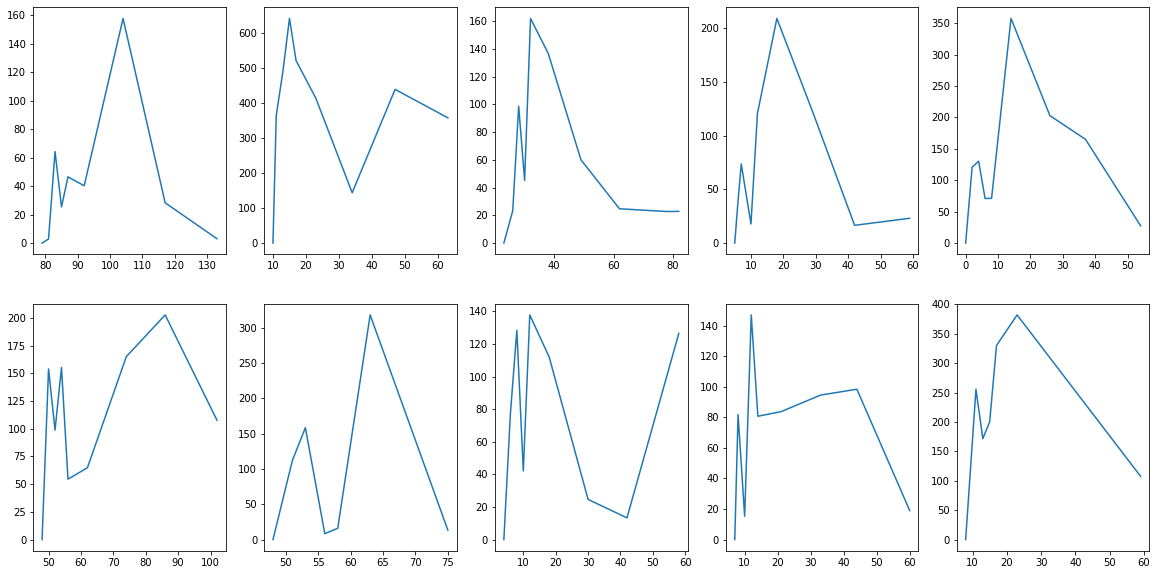

In [9]:
import math
N_SAMPLES = 10

# initiate plot
n_rows = math.ceil(N_SAMPLES / 5)
n_cols = 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))


# plot
for plot in range(N_SAMPLES):
  id = np.random.choice(list(theta_dict)) # generate random sample

  # get data
  theta = theta_dict[id]
  weeks = weeks_dict[id]

  # plot theta
  ax[plot // 5, plot % 5].plot(weeks, theta)

plt.show()

# Plot n_samples of ground truth exponent functions

In [ ]:
N_SAMPLES = 10

# plot
plt.figure(figsize=(20, 5))
for plot in range(N_SAMPLES):
  id = np.random.choice(list(func_dict))
  func = func_dict[id]
  visualize.plot_patient_exp(id, exp_function=func)

# Exemine outliers
## Plot 12 FVC diagrams and the cooks distance for every point

In [ ]:
from statsmodels.formula.api import ols
N_SAMPLES = 12

# initiate plot
n_rows = math.ceil(N_SAMPLES / 3)
n_cols = 3
fig, ax = plt.subplots(n_rows, n_cols, figsize=(30, 8 * n_rows))

for plot in range(N_SAMPLES):
  id = np.random.choice(train_table["Patient"].unique())  # select a random sample
  hist = table_data.get_fvc_hist(train_table, id)

  # get cooks distance
  m = ols("FVC ~ Weeks", hist).fit() # fit a statsmodels ols
  infl = m.get_influence() # check influens on every point
  cooks_dists = infl.summary_frame()["cooks_d"] # show cooks distance for every point
  # plot
  visualize.plot_patient_exp(id, func_dict[id], ax=ax[plot//3, plot % 3])
  ax[plot//3, plot%3].set_title(id)
  
  # anotetae cooks distance
  for i, dist in enumerate(cooks_dists):
    ax[plot//3, plot%3].annotate('{0:.2f}'.format(dist), (hist["Weeks"].iloc[i], hist["FVC"].iloc[i]))

plt.show()

## Now lets try to remove from each graph the point with the largest cooks distance which is not the first or the last point

In [ ]:
def get_cooks_distance(observations):
  """Return the cooks distance of every point in observations"""
  x, y = observations.columns  # get predictor and response variable

  m = ols("{} ~ {}".format(x, y), observations).fit() # fit a statsmodels ols
  infl = m.get_influence() # check influens on every point
  cooks_dists = infl.summary_frame()["cooks_d"] # show cooks distance for every poin

  return cooks_dists


def remove_outlier(fvc_hist):
  """Remove the point with the largest cooks distance from the fvc observations. Do not remove the first nor the last point"""
  max_ind = get_cooks_distance(fvc_hist)[1:-1].argmax() # remove first and last
  fvc_hist = fvc_hist.reset_index(drop=True)
  return fvc_hist.drop(max_ind, axis=0)


def get_patient_fvc_exp(hist):
    """Get a patient exponential coefficient.
    Each patient has his own fvc progression that can be described by Ie^-kt.
    Wheres I is the initial FCV measure, k is the exponential coefficient and t is time.
    Args:
        table--data table with records
    """

    # compute logs
    weeks = hist["Weeks"]
    log_fvc = np.log(hist["FVC"])

    # center weeks - set 0 for first measurement
    weeks = weeks - hist.iloc[0, 0]

    # regress to find logI -kt
    neg_k, logI = np.polyfit(weeks, log_fvc, deg=1)

    return -neg_k

In [ ]:
# ID00408637202308839708961
id = "ID00219637202258203123958"
visualize.plot_patient_exp(id, exp_function=func_dict[id])
hist = table_data.get_fvc_hist(train_table, id)

# remove outliers
hist_corrected = remove_outlier(hist)


# fit second exponent
i_week, i_fvc = table_data.get_initial_fvc(id)
k = get_patient_fvc_exp(hist_corrected)

new_exp = predict.ExpFunc(i_fvc, k, i_week)

visualize.plot_patient_exp(id, exp_function=new_exp)


## It seems that every datapoint is cruical for fitting the exponent fucntion..

In [ ]:
id = np.random.choice(list(func_dict))
visualize.plot_patient_exp(id, exp_function=func_dict[id])
print(id)

# Case study: Patient "ID00007637202177411956430"

In [ ]:
# visualize fvc
visualize.plot_patient_exp("ID00007637202177411956430")

In [ ]:
# visualize log of exp
hist = table_data.get_fvc_hist(train_table, "ID00007637202177411956430") # get hist
log_fvc = np.log(hist["FVC"])
plt.scatter(hist["Weeks"], log_fvc)

In [ ]:
# show cooks distance
log_hist = hist.copy()
log_hist["FVC"] = log_fvc
m = ols("FVC ~ Weeks", log_hist).fit() # fit ols
infl = m.get_influence()
cooks_d = infl.summary_frame()["cooks_d"]
print(cooks_d)

In [ ]:
points = np.linspace(1, 50, 25)
y = [np.exp(-0.05 * point) for point in points]
print(y)
plt.scatter(points, y)

In [ ]:
plt.scatter(points, np.log(y))